In [1]:
#Needed Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import sys

from tqdm import tqdm

import json
from pathlib import Path

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
tqdm.pandas()

sns.set(font_scale = 1.25)
sns.set_style("whitegrid")
# pd.set_option('display.max_rows', None)

SOURCES = ['Apache', 'Hyperledger', 'IntelDAOS', 
           'JFrog', 'Jira', 'JiraEcosystem', 
           'MariaDB', 'Mindville', 'MongoDB', 
           'Qt', 'RedHat', 'Sakai', 
           'SecondLife', 'Sonatype', 'Spring']

In [3]:
def load_data(source):
    #Loading Issues
    filename = '../../data/crawl/issues_'+source.lower()+'.csv'
    issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';', index_col=['issue_id'])
    
    #Loading Links
    filename = '../../data/crawl/clean_links_'+source.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0, sep=';')
    
    return issues, links

In [4]:
link_dict = {}
issue_dict = {}

for s in SOURCES:
    print(s.upper())
    issues, links = load_data(s)
    link_dict[s] = links
    issue_dict[s] = issues

APACHE
HYPERLEDGER
INTELDAOS
JFROG
JIRA
JIRAECOSYSTEM
MARIADB
MINDVILLE
MONGODB
QT
REDHAT
SAKAI
SECONDLIFE
SONATYPE
SPRING


In [5]:
s = 'Spring'
links = link_dict[s]

links[links['linktype']=='Subtask']

,name,linktype,issue_id_1,issue_id_2,issues
53,XD-3654_XD-3655,Subtask,XD-3654,XD-3655,"['XD-3654', 'XD-3655']"
73,XD-3624_XD-3660,Subtask,XD-3624,XD-3660,"['XD-3624', 'XD-3660']"
74,XD-3624_XD-3674,Subtask,XD-3624,XD-3674,"['XD-3624', 'XD-3674']"
129,XD-3563_XD-3564,Subtask,XD-3563,XD-3564,"['XD-3563', 'XD-3564']"
175,XD-3512_XD-3625,Subtask,XD-3512,XD-3625,"['XD-3512', 'XD-3625']"
...,...,...,...,...,...
14454,AMQP-75_AMQP-80,Subtask,AMQP-75,AMQP-80,"['AMQP-75', 'AMQP-80']"
14455,AMQP-75_AMQP-89,Subtask,AMQP-75,AMQP-89,"['AMQP-75', 'AMQP-89']"
14458,AMQP-36_AMQP-37,Subtask,AMQP-36,AMQP-37,"['AMQP-36', 'AMQP-37']"
14460,AMQP-5_AMQP-6,Subtask,AMQP-5,AMQP-6,"['AMQP-5', 'AMQP-6']"


In [6]:
links = link_dict[s]

links[links['linktype']=='Epic-Relation']

,name,linktype,issue_id_1,issue_id_2,issues
4,XD-3742_XD-1607,Epic-Relation,XD-3742,XD-1607,"['XD-1607', 'XD-3742']"
6,XD-3735_XD-2053,Epic-Relation,XD-3735,XD-2053,"['XD-2053', 'XD-3735']"
7,XD-3733_XD-696,Epic-Relation,XD-3733,XD-696,"['XD-3733', 'XD-696']"
8,XD-3714_XD-2629,Epic-Relation,XD-3714,XD-2629,"['XD-2629', 'XD-3714']"
11,XD-3708_XD-3477,Epic-Relation,XD-3708,XD-3477,"['XD-3477', 'XD-3708']"
...,...,...,...,...,...
13392,DATAJDBC-318_DATAJDBC-452,Epic-Relation,DATAJDBC-318,DATAJDBC-452,"['DATAJDBC-318', 'DATAJDBC-452']"
13432,DATAJDBC-101_DATAJDBC-452,Epic-Relation,DATAJDBC-101,DATAJDBC-452,"['DATAJDBC-101', 'DATAJDBC-452']"
14220,BATCH-2105_BATCH-2103,Epic-Relation,BATCH-2105,BATCH-2103,"['BATCH-2103', 'BATCH-2105']"
14221,BATCH-2104_BATCH-2103,Epic-Relation,BATCH-2104,BATCH-2103,"['BATCH-2103', 'BATCH-2104']"


In [7]:
def print_linktypes(SOURCE):
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
        
    num_links = len(links)
    num_issues = len(issues)
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = temp.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    try:
        same_ratio = round(temp['sameproject'].value_counts().loc[True]/len(temp)*100, 2)
    except:
        same_ratio = 0
    try:
        cross_ratio = round(temp['sameproject'].value_counts().loc[False]/len(temp)*100, 2)
    except:
        cross_ratio = 0

    blub = links.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentages'] = blub['counts'].apply(lambda x: round(x/len(links),3)*100)
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in temp.linktype.value_counts().index:
        link_temp = temp[temp['linktype'] == i]
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
        link_index = blub.index[blub['linktype']==i]
        link_index = list(link_index)
        blub['sameproject'].iloc[link_index[0]] = same_ratio_temp
        blub['crossproject'].iloc[link_index[0]] = cross_ratio_temp
        
    return num_issues, num_links, len(links.linktype.unique()), round(len(link_set)/len(issue_set), 3), len(link_set), same_ratio, cross_ratio, blub

In [8]:
overview = pd.DataFrame(columns = ['Source', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#LinkedIssues', "%SameProject", "%CrossProject"])
link_dist = pd.DataFrame(columns=['source', 'linktype', 'counts'])
j = 0
for s in SOURCES:
    i, l, ltu, pi, li, sr, cr, blub = print_linktypes(s)
    overview.loc[j] = [s, i, l, ltu, pi, li, sr, cr]
    
    j+=1
    
    frames = [link_dist, blub]
    #concatenate dataframes
    link_dist = pd.concat(frames, sort=False)

In [9]:
overview

,Source,#Issues,#Links,#Linktypes,%IssuesWithLinks,#LinkedIssues,%SameProject,%CrossProject
0,Apache,1014926,255767,22,0.285,289589,94.77,5.23
1,Hyperledger,28146,16304,8,0.549,15457,95.38,4.62
2,IntelDAOS,9474,2599,13,0.308,2918,96.73,3.27
3,JFrog,15535,3229,11,0.286,4439,91.76,8.24
4,Jira,274545,99819,19,0.467,128336,56.58,43.42
5,JiraEcosystem,41866,11398,20,0.330,13804,93.23,6.77
6,MariaDB,31229,14618,8,0.445,13895,97.46,2.54
7,Mindville,2134,44,4,0.040,85,95.45,4.55
8,MongoDB,137172,63821,15,0.452,61950,80.91,19.09
9,Qt,148579,40105,12,0.302,44810,93.08,6.92


In [10]:
print(overview.sum())
print(overview.mean())

Source              ApacheHyperledgerIntelDAOSJFrogJiraJiraEcosyst...
#Issues                                                       2265463
#Links                                                         666734
#Linktypes                                                        187
%IssuesWithLinks                                                5.005
#LinkedIssues                                                  759760
%SameProject                                                   1356.6
%CrossProject                                                   143.4
dtype: object
#Issues             151030.866667
#Links               44448.933333
#Linktypes              12.466667
%IssuesWithLinks         0.333667
#LinkedIssues        50650.666667
%SameProject            90.440000
%CrossProject            9.560000
dtype: float64


In [11]:
link_dist[link_dist["linktype"]=='Backports']

,source,linktype,counts,percentages,sameproject,crossproject
10,MongoDB,Backports,170,0.3,95.29,4.71


In [12]:
print(link_dist.linktype.unique())
print(len(link_dist.linktype.unique()))

['Subtask' 'Reference' 'Duplicate' 'Blocker' 'Epic-Relation' 'dependent'
 'Incorporates' 'Regression' 'Cloners' 'Required' 'Container' 'Related'
 'Supercedes' 'Problem/Incident' 'Child-Issue' 'Blocked' 'Completes'
 'Dependent' 'Dependency' 'Testing' 'Parent Feature' 'Issue split'
 'Relates' 'Blocks' 'Git Code Review' 'Cloners (migrated)'
 'Gantt End to Start' 'Verify' 'Implement' 'Gantt End to End'
 'Gantt Start to Start' 'Relationship' 'Trigger' 'Contains(WBSGantt)'
 'Finish-to-Finish link (WBSGantt)' 'Part' 'Detail' 'Cause' 'Derived'
 'Supersession' 'Relate' 'Bonfire Testing' 'Split' 'Depends' 'Resolve'
 'Follows' 'Bonfire testing' 'Epic' 'Preceded By'
 'Polaris datapoint issue link' 'Polaris issue link' 'PartOf' 'Documented'
 'Gantt Dependency' 'Backports' 'Tested' 'Initiative' 'Work Breakdown'
 'Replacement' 'Test' 'Covered' 'Superset' 'Sequence' 'Causality'
 'Cloners (old)' 'Documentation' 'Parent-Relation'
 'multi-level hierarchy [GANTT]' 'finish-start [GANTT]' 'Account'
 'Gantt:

In [13]:
type_dict={'Backports': 'Backport', 
           
    'Blocked': 'Block',
    'Blocker': 'Block',
    'Blocks': 'Block',
           
    'Bonfire Testing': 'Bonfire Testing', 
    'Bonfire testing': 'Bonfire Testing', 
    'Git Code Review': 'Bonfire Testing', 
    'Testing': 'Bonfire Testing',
           
    'Causality': 'Cause', 
    'Cause': 'Cause',
    'Caused': 'Cause', 
    'Problem/Incident': 'Cause',
           
    'Child-Issue': 'Parent-Child', 
    'Parent Feature': 'Parent-Child',
    'Parent/Child': 'Parent-Child',
    'multi-level hierarchy [GANTT]': 'Parent-Child',
    'Parent-Relation': 'Parent-Child',
           
    'Cloners': 'Clone', 
    'Cloners (old)': 'Clone', 
           
    'Collection': 'Incorporate', 
    'Container': 'Incorporate',
    'Contains(WBSGantt)': 'Incorporate', 
    'Incorporate': 'Incorporate', 
    'Incorporates': 'Incorporate', 
    'Part': 'Incorporate',
    'PartOf': 'Incorporate',
    'Superset': 'Incorporate', 
           
    'Completes': 'Fix', 
    'Fixes': 'Fix',
    'Resolve': 'Fix',
           
    'Depend': 'Depend', 
    'Dependency': 'Depend', 
    'Dependent': 'Depend', 
    'Depends': 'Depend', 
    'Gantt Dependency': 'Depend',
    'dependent': 'Depend',
           
    'Derived': 'Derive',
           
    'Detail': 'Detail', 
           
    'Documentation': 'Documented',
    'Documented': 'Documented',
    
    'Duplicate': 'Duplicate',
           
    'Epic': 'Epic', 
    'Epic-Relation': 'Epic',
    
    'Finish-to-Finish link (WBSGantt)': 'finish-finish', 
    'Gantt End to End': 'finish-finish', 
    'Gantt: finish-finish': 'finish-finish',
    'finish-finish [GANTT]': 'finish-finish', 
    
    'Gantt End to Start': 'finish-start', 
    'Gantt: finish-start': 'finish-start',
    'finish-start [GANTT]': 'finish-start',

    'Gantt Start to Start': 'start-start', 
    
    'Gantt: start-finish': 'start-finish',
    
    'Follows': 'Follow', 
    'Sequence': 'Follow', 
    
    'Implement': 'Implement', 
    'Implements': 'Implement', 
    
    'Issue split': 'Split',
    'Split': 'Split',
    'Work Breakdown': 'Split',
    
    'Preceded By': 'Precede', 
    
    'Reference': 'Relate',
    'Relate': 'Relate',
    'Related': 'Relate', 
    'Relates': 'Relate',
    'Relationship': 'Relate',
    
    'Regression': 'Breaks',
    
    'Replacement': 'Replace',
    
    'Required': 'Require',
    
    'Supercedes': 'Supercede',
    'Supersede': 'Supercede',
    'Supersession': 'Supercede', 
    
    'Test': 'Test', 
    'Tested': 'Test',
    
    'Trigger': 'Trigger',
          
    'Subtask': 'Subtask'}

In [14]:
def print_cleaned_linktypes(SOURCE):  
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))
    
    links['mappedtype'] = links['linktype'].map(type_dict)
            
    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = links.mappedtype.value_counts().rename_axis('mappedtype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentageOfLinks'] = blub['counts'].apply(lambda x: round(x/len(links),10)*100)
    blub['percentagesOfIssues'] = 0
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in range(len(blub)):
        mappedType = blub['mappedtype'].iloc[i]
        link_temp = temp[temp['mappedtype'] == mappedType]
        lt_set = set(link_temp['issue_id_1']).union(set(link_temp['issue_id_2']))
        blub['percentagesOfIssues'].iloc[i] = round(len(lt_set)/len(issue_set),10)*100
        
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
            
        blub['sameproject'].iloc[i] = same_ratio_temp
        blub['crossproject'].iloc[i] = cross_ratio_temp
        
    return len(links.mappedtype.unique()), blub

In [15]:
overview_cl = pd.DataFrame(columns=['Source', '#Linktypes'])
link_dist_cl = pd.DataFrame(columns=['source', 'mappedtype', 'counts'])
j = 0
for s in SOURCES:
    ltu, blub = print_cleaned_linktypes(s)
    overview_cl.loc[j] = [s, ltu]
    
    j+=1
    
    frames = [link_dist_cl, blub]
    #concatenate dataframes
    link_dist_cl = pd.concat(frames, sort=False)

In [16]:
len(link_dist_cl.mappedtype.unique())

30

In [17]:
link_dist_cl['mappedtype'].value_counts().sort_index(ascending=True)

Backport            1
Block               9
Bonfire Testing     5
Breaks              2
Cause               7
Clone              12
Depend              9
Derive              1
Detail              1
Documented          2
Duplicate          13
Epic                8
Fix                 3
Follow              3
Implement           2
Incorporate         7
Parent-Child        3
Precede             1
Relate             14
Replace             1
Require             1
Split               9
Subtask            14
Supercede           4
Test                2
Trigger             1
finish-finish       4
finish-start        3
start-finish        1
start-start         3
Name: mappedtype, dtype: int64

In [18]:
#used in more than 7 projects
common_lt = (link_dist_cl.mappedtype.value_counts()>=15*0.45).rename_axis('mappedtype').reset_index(name='valid')
common_lt_set = common_lt[common_lt['valid']==True]['mappedtype'].values

In [19]:
commontypes = link_dist_cl[link_dist_cl['mappedtype'].isin(common_lt_set)]

In [20]:
commontypes.groupby(['mappedtype']).agg({'counts': ['sum'], 'percentageOfLinks': ['mean'], 'sameproject': ['mean'], 'crossproject': ['mean']})

,counts,percentageOfLinks,sameproject,crossproject
,sum,mean,mean,mean
mappedtype,,,,
Block,39322,8.589290,87.211111,12.788889
Cause,10687,3.204718,85.558571,14.441429
Clone,26708,4.249911,83.675000,16.325000
Depend,36344,8.101038,81.591111,18.408889
Duplicate,73105,13.645744,96.040000,3.960000
Epic,39892,14.517931,98.235000,1.765000
Incorporate,24957,4.100860,93.185714,6.814286
Relate,225138,35.610431,87.464286,12.535714


In [21]:
#easier to copy for Latex
pivot = pd.pivot_table(commontypes, values='percentageOfLinks', index=['source'],
                    columns=['mappedtype'], aggfunc=np.sum)
pivot_new = pd.DataFrame()
pivot_new = pivot[common_lt_set]
pivot_new.round(1)
pivot_new['Coverage'] = pivot_new.sum(axis=1)

print("-----Averages-----")
print(pivot_new.mean())
print("-----Standard Deviation-----")
print(pivot_new.std())

pivot_new['Relate'] = pivot_new['Relate'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Subtask'] = pivot_new['Subtask'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Duplicate'] = pivot_new['Duplicate'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Clone'] = pivot_new['Clone'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Depend'] = pivot_new['Depend'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Epic'] = pivot_new['Epic'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Split'] = pivot_new['Split'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Block'] = pivot_new['Block'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Incorporate'] = pivot_new['Incorporate'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Cause'] = pivot_new['Cause'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Coverage'] = pivot_new['Coverage'].apply(lambda x: str(round(x,2))+'%')

print(pivot_new.round(2).to_latex())

-----Averages-----
mappedtype
Subtask        20.891880
Relate         35.610431
Duplicate      13.645744
Clone           4.249911
Split           1.132109
Depend          8.101038
Block           8.589290
Epic           14.517931
Cause           3.204718
Incorporate     4.100860
Coverage       89.807359
dtype: float64
-----Standard Deviation-----
mappedtype
Subtask        13.762800
Relate         13.047804
Duplicate       9.110154
Clone           5.706761
Split           2.146365
Depend          7.453112
Block           8.176793
Epic           12.539531
Cause           1.864004
Incorporate     3.071437
Coverage       20.548479
dtype: float64
\begin{tabular}{llllllllllll}
\toprule
mappedtype & Subtask &  Relate & Duplicate &   Clone &  Split &  Depend &   Block &    Epic &  Cause & Incorporate & Coverage \\
source        &         &         &           &         &        &         &         &         &        &             &          \\
\midrule
Apache        &  32.76\% &  28.28\% &    

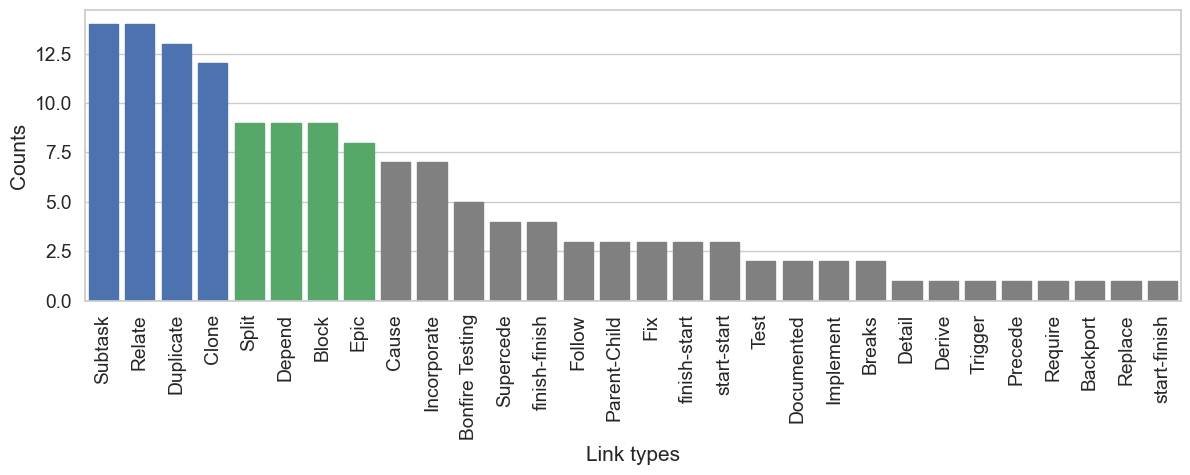

In [22]:
link_dist_count = link_dist_cl['mappedtype'].value_counts()

fig = plt.gcf()
fig.set_size_inches(12, 5)

plt.xticks(rotation=90)
ax = sns.barplot(link_dist_count.index, link_dist_count.values)

for bar in ax.patches:
    if bar.get_height() >= 15*0.75:
        bar.set_color('b')  
    elif bar.get_height() > 15*0.5:
        bar.set_color('g') 
    else:
        bar.set_color('grey')

ax.set(xlabel ="Link types", ylabel = "Counts")

plt.tight_layout()
        
plt.savefig('pictures/link_dist_cleaned.png', dpi = 300)

In [23]:
tidy2 = link_dist_cl.melt(id_vars='mappedtype').rename(columns=str.title)
tidy = tidy2[(tidy2['Variable']=='percentageOfLinks')]

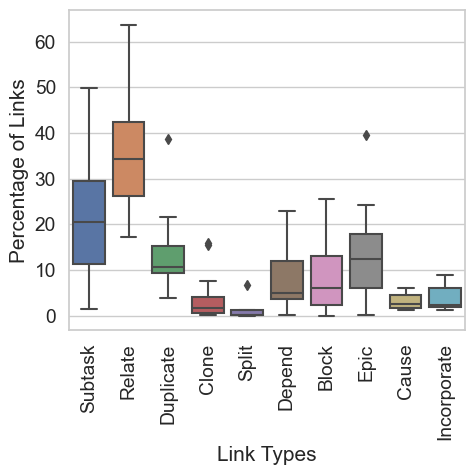

In [24]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.xticks(rotation=90)
ax = sns.boxplot(x='Mappedtype', y='Value', data=tidy, order=common_lt_set)


for i in [0,1,2,3]:
    try:
        mybox = ax.artists[i]
        mybox.set_facecolor('b')
    except:
        continue

for i in [4,5,6,7,8]:
    try:
        mybox = ax.artists[i]
        mybox.set_facecolor('g')
    except:
        continue  
for i in [9]:
    try:
        mybox = ax.artists[i]
        mybox.set_facecolor('grey')
    except:
        continue

ax.set(xlabel ="Link Types", ylabel = "Percentage of Links")

plt.tight_layout()
        
plt.savefig('pictures/link_usage_cleaned.png', dpi = 300)


In [25]:
tidy3 = link_dist_cl.melt(id_vars='mappedtype').rename(columns=str.title)
tidy4 = tidy3[(tidy3['Variable']=='percentagesOfIssues')]

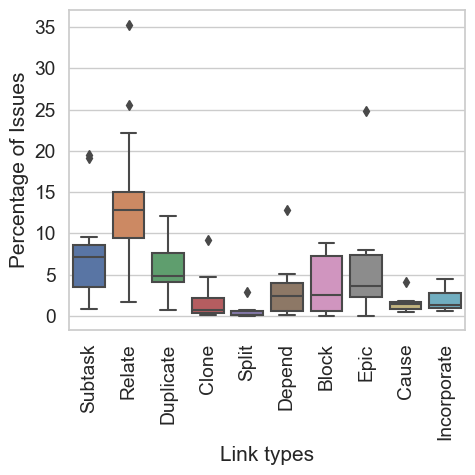

In [26]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.xticks(rotation=90)
ax = sns.boxplot(x='Mappedtype', y='Value', data=tidy4, order=common_lt_set)

for i in [0,1,2,3]:
    try:
        mybox = ax.artists[i]
        mybox.set_facecolor('b')
    except:
        continue
    
for i in [4,5,6,7,8]:
    try:
        mybox = ax.artists[i]
        mybox.set_facecolor('g')
    except:
        continue
    
for i in [9]:
    try:
        mybox = ax.artists[i]
        mybox.set_facecolor('grey')
    except:
        continue


ax.set(xlabel ="Link types", ylabel = "Percentage of Issues")

plt.tight_layout()
        
plt.savefig('pictures/link_usage_issues_cleaned.png', dpi = 300)


In [27]:
pivot_extra = pivot.copy()
pivot_extra['Other'] = 100-pivot.sum(axis=1)

In [28]:
pivot_extra

mappedtype,Block,Cause,Clone,Depend,Duplicate,Epic,Incorporate,Relate,Split,Subtask,Other
source,,,,,,,,,,,
Apache,6.079361,1.214387,1.689428,5.086270,10.136179,4.889607,4.078321,28.284337,0.010166,32.757549,5.774396e+00
Hyperledger,8.243376,NaN,2.925662,NaN,3.913150,39.616045,NaN,17.216634,0.478410,27.563788,4.293425e-02
IntelDAOS,25.548288,NaN,1.462101,NaN,9.696037,NaN,NaN,39.322816,NaN,10.542516,1.342824e+01
JFrog,NaN,NaN,0.836172,7.928151,19.913286,NaN,1.362651,27.376897,NaN,36.048312,6.534531e+00
Jira,0.988790,1.787235,2.871197,0.165299,21.724321,NaN,2.453441,63.762410,0.181328,2.477484,3.588495e+00
JiraEcosystem,5.948412,3.860326,1.763467,1.114231,15.274610,24.249868,1.789788,22.925075,1.193192,20.038603,1.842429e+00
MariaDB,12.990833,5.965248,NaN,NaN,9.399371,6.444110,7.894377,51.060337,0.150499,6.095225,1.000001e-08
Mindville,2.272727,NaN,15.909091,NaN,38.636364,NaN,NaN,43.181818,NaN,NaN,0.000000e+00
MongoDB,NaN,1.695367,0.316510,22.860814,13.454819,15.902289,NaN,39.910061,1.178296,1.391392,3.290453e+00


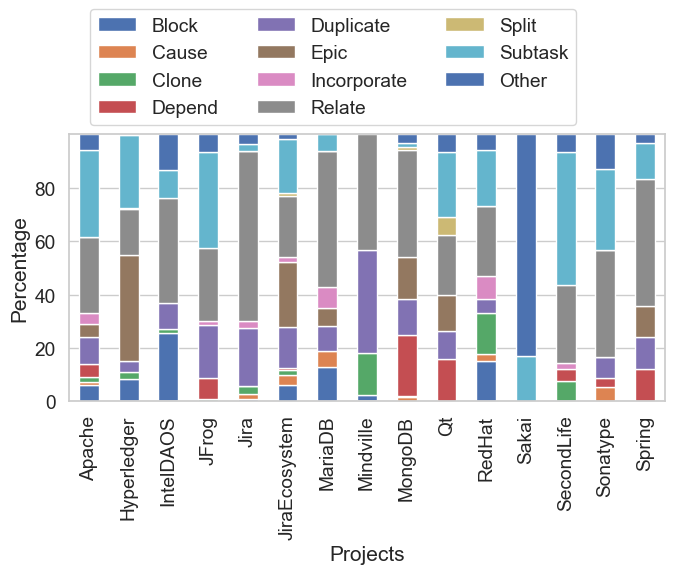

In [29]:
f, (ax) = plt.subplots(1, 1, figsize=(7, 6), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(10, 10)

ax = pivot_extra.plot(kind='bar', stacked=True, mark_right = True, ax=ax)
ax.set(xlabel ="Projects", ylabel = "Percentage")

plt.legend(bbox_to_anchor=(0.02, 1, 1, 0), ncol=3)

plt.tight_layout()

ax.figure.savefig("pictures/link_type_distribution_cleaned.png")